In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker #Brough in from google search
from sqlalchemy import create_engine, func
from sqlalchemy import Table, Column, Integer, String, MetaData #Brough in from google search
from sqlalchemy.ext.declarative import declarative_base

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Base = sqlalchemy.ext.automap.automap_base()
Base = automap_base()
Base.prepare(engine, reflect=True)

# Get the table names
inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()

for table_name in table_names:
    print(table_name)

measurement
station


In [6]:
# View all of the classes that automap found
# Get a list of all the class names
class_names = Base.classes.keys()

# Print the class names
for class_name in class_names:
    print(class_name)

measurement
station


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station 

In [9]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

In [10]:
results = session.query(measurement).limit(5).all() # Limit the results to the first 5 rows

for row in results:
    print(row.id, row.station, row.date, row.prcp, row.tobs)

1 USC00519397 2010-01-01 0.08 65.0
2 USC00519397 2010-01-02 0.0 63.0
3 USC00519397 2010-01-03 0.0 74.0
4 USC00519397 2010-01-04 0.0 76.0
5 USC00519397 2010-01-06 None 73.0


In [11]:
results = session.query(station).limit(5).all() # Limit the results to the first 5 rows

for row in results:
    print(row.id, row.station, row.name, row.latitude, row.longitude, row.elevation)

1 USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0
2 USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0
4 USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9
5 USC00518838 UPPER WAHIAWA 874.3, HI US 21.4992 -158.0111 306.6


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

print("The most recent date in the dataset:", most_recent_date)

The most recent date in the dataset: 2017-08-23


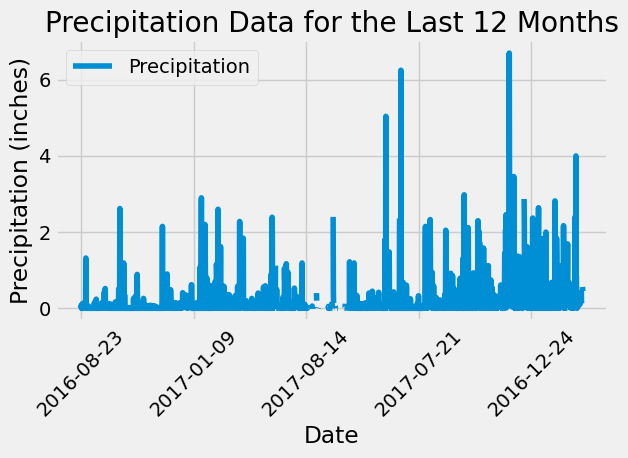

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_year_prcp = session.query(func.date(func.max(measurement.date), '-12 months')).scalar()

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= previous_year_prcp).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True) # Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=45)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = prcp_df['Precipitation'].count()
mean = prcp_df['Precipitation'].mean()
std = prcp_df['Precipitation'].std()
min = prcp_df['Precipitation'].min()
Quantile25 = prcp_df['Precipitation'].quantile(0.25)
Quantile50 = prcp_df['Precipitation'].quantile(0.50)
Quantile75 = prcp_df['Precipitation'].quantile(0.75)
max = prcp_df['Precipitation'].max()

print(f"Count: {count:.6f}")
print(f"Mean: {mean:.6f}")
print(f"Standard Deviation: {std:.6f}")
print(f"Min: {min:.6f}")
print(f"25th Quantile: {Quantile25:.6f}")
print(f"50th Quantile: {Quantile50:.6f}")
print(f"75th Quantile: {Quantile75:.6f}")
print(f"Max: {max:.6f}")

Count: 2021.000000
Mean: 0.177279
Standard Deviation: 0.461190
Min: 0.000000
25th Quantile: 0.000000
50th Quantile: 0.020000
75th Quantile: 0.130000
Max: 6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).count()

print("Total Number of Stations:", total_stations)

Total Number of Stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print("Most Active Station:", most_active_station)
print("Lowest Temperature:", lowest_temp)
print("Highest Temperature:", highest_temp)
print("Average Temperature:", avg_temp)

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


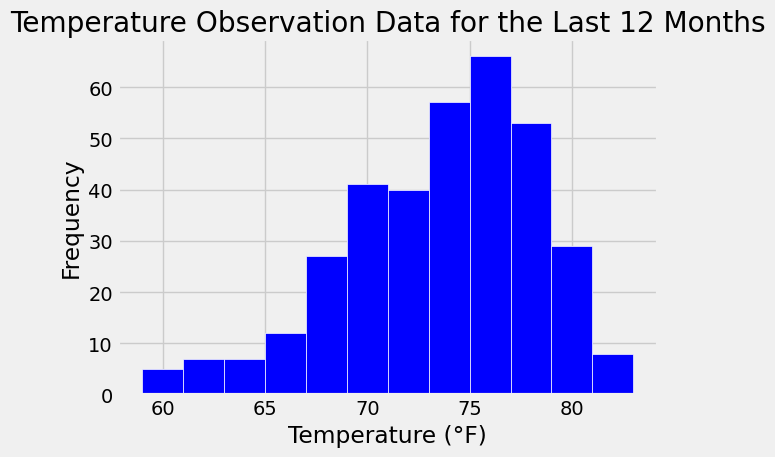

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = session.query(func.date(func.max(measurement.date), '-12 months')).scalar()

# Query temperature observation data for the most active station and the last 12 months
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station, measurement.date >= one_year_ago).all()

# Convert the query result to a pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Query station information for the most active station
# active_station_info = session.query(station).filter(station.station == text(most_active_station)).first()

# # Print station information
# print("Station Information:")
# print("Station ID:", active_station_info.station)
# print("Name:", active_station_info.name)
# print("Temperature:", active_station_info.temperature)


# Plot the temperature data as a histogram
plt.hist(temperature_df['Temperature'], bins=12, color='blue', edgecolor='white')
plt.hist(temperature_df['Temperature'], bins=12, color='blue', edgecolor='white')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()